lstm2

과정요약: 이상점 제거+ normalize+ denormalize

결과요약: RMSE: 0.24234837293624878 

추가의견) 개인적으로 이상점을 제거한 후 normalize를 하면 rmse가 커질 수 밖에 없다고 생각함. 다음시도(lstm3)은 이상점을 제거하지 않고 normalize를 하고, lstm4에서는 이상점을 제거하고 normalize를 하지 않는 것을 시도하겠다.

추가의견2) 처음에는 denormalize과정 없이 rmse를 구했는데, 이것보다는 denormalize를 한 후 rmse를 구하여 모델간 비교를 하는 것이 더 적절한 것 같다. normalize는 어디까지나 변환이니 항상 변환을 할때는 역변환을 하여 원본 데이터 형태m로 생각하는 것이 덜 헷갈리고, 결과값에 대한 더욱 직관적인 이해가 가능할 것 같다. 그리고, 여러 형태의 data transformation이 있는데 normalize 가장 마지막 단계의 data transformation인 것 같다. 다른 로그나 루트 변환을 한 후 normalization을 하고, 그리고 예측값이 모델을 통해 생성되면 바로 denormalize하고...예측(뉴럴) 모델의 input직전과 output직후.

Data import

시도 내용 요약:
주중(1)/주말(2) + 겨울(1)봄(2)여름(3)가을(4) // 

이미 lstm이라는 것이 sequence 개념이 있으므로 시간축(1~397)를 feature로 설정하는 것은 의미가 없을 듯 하여 LSTM 시도2에서는 제외함

https://bigdatascientistblog.wordpress.com/2015/10/02/feature-engineering-with-dates-part-1/

에 따르면 날짜 datestampe에서 9가지의 특성을 끌어낼 수 있다고 한다. 따라서 이를 적용해보고자 한다.

year, month, day, day of week, week of year, hour of day

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
tf.set_random_seed(77)

In [2]:
columns=['date','sales']

txs=pd.read_table('./lstmData/lstmPrac2.csv', sep=',',header=None,names=columns )
txs.info()
txs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
date     397 non-null object
sales    397 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.3+ KB


,date,sales
0,2016-01-01,34
1,2016-01-02,41
2,2016-01-03,54
3,2016-01-04,41
4,2016-01-05,35


In [3]:
from datetime import datetime                    

# 1. 기본 feature

In [4]:
year = lambda x: datetime.strptime(x, "%Y-%m-%d" ).year  
day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d" ).weekday()
month = lambda x: datetime.strptime(x, "%Y-%m-%d" ).month
# please read docs on how week numbers are calculate
week_number = lambda x: datetime.strptime(x, "%Y-%m-%d" ).strftime('%V')

# 2. 추가 feature

In [5]:
seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d" ).month-1)]

In [6]:
txs['year'] = txs['date'].map(year)
txs['month']=txs['date'].map(month)
txs['week_number']=txs['date'].map(week_number)
txs['season']=txs['date'].map(season)
txs['day_of_week']=txs['date'].map(day_of_week)
# txs['week_number']=txs['date'].map(week_number)
txs

,date,sales,year,month,week_number,season,day_of_week
0,2016-01-01,34,2016,1,53,0,4
1,2016-01-02,41,2016,1,53,0,5
2,2016-01-03,54,2016,1,53,0,6
3,2016-01-04,41,2016,1,01,0,0
4,2016-01-05,35,2016,1,01,0,1
5,2016-01-06,44,2016,1,01,0,2
6,2016-01-07,50,2016,1,01,0,3
7,2016-01-08,42,2016,1,01,0,4
8,2016-01-09,42,2016,1,01,0,5
9,2016-01-10,66,2016,1,01,0,6


pandas를 통해 구한 각 feature는 list()로 우리의 기준type인 list로 변경이 가능

# 3. 추가 가공

이상점 제거, normalization, bucketization 을 하여 새로운 열을 생성하는 방향으로

## 이상점 제거

이상점 제거를 위해 평균과 표준편차를 구한다. 이상점의 기준은 일단 평균+-2*sd로 설정

In [26]:
xySales=list(txs['sales'])

In [25]:
mean=np.mean(xySales)
std=np.std(xySales)

In [11]:
for i in range(len(xySales)):
    if (xySales[i]<mean-2*std or xySales[i]>mean+2*std):
         xySales[i]=int(mean)
        

In [12]:
xySales

[34,
 41,
 54,
 41,
 35,
 44,
 50,
 42,
 42,
 66,
 50,
 55,
 56,
 53,
 44,
 54,
 54,
 50,
 40,
 49,
 28,
 72,
 71,
 53,
 43,
 38,
 55,
 49,
 43,
 49,
 49,
 44,
 39,
 52,
 45,
 33,
 43,
 40,
 46,
 49,
 50,
 37,
 37,
 45,
 48,
 48,
 38,
 60,
 31,
 35,
 53,
 70,
 62,
 48,
 51,
 49,
 38,
 32,
 39,
 35,
 30,
 36,
 31,
 31,
 44,
 41,
 41,
 45,
 46,
 45,
 41,
 47,
 48,
 40,
 42,
 38,
 38,
 45,
 48,
 62,
 46,
 38,
 62,
 81,
 40,
 45,
 42,
 53,
 53,
 56,
 53,
 47,
 61,
 64,
 62,
 37,
 65,
 54,
 44,
 46,
 50,
 43,
 53,
 63,
 52,
 2,
 0,
 0,
 72,
 59,
 75,
 47,
 44,
 77,
 90,
 93,
 47,
 61,
 77,
 35,
 50,
 58,
 33,
 41,
 36,
 64,
 49,
 53,
 60,
 43,
 41,
 55,
 45,
 18,
 60,
 69,
 54,
 39,
 50,
 44,
 54,
 57,
 82,
 57,
 44,
 56,
 51,
 55,
 28,
 56,
 54,
 36,
 12,
 25,
 41,
 11,
 6,
 9,
 35,
 29,
 24,
 23,
 14,
 21,
 20,
 25,
 23,
 27,
 31,
 16,
 14,
 30,
 32,
 75,
 35,
 26,
 12,
 21,
 23,
 28,
 25,
 31,
 21,
 17,
 10,
 29,
 34,
 28,
 20,
 36,
 23,
 15,
 42,
 28,
 24,
 29,
 20,
 14,
 18,
 27,
 22,


## Normalization

In [29]:
def minMaxNormalizer(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)

## Denormalization

In [28]:
def minMaxDeNormalizer(data):
    shift=np.min(originalData)
    multiplier=np.max(originalData)-np.min(originalData)
    return (data+shift)*multiplier 

In [14]:
originalSales=xySales

[34,
 41,
 54,
 41,
 35,
 44,
 50,
 42,
 42,
 66,
 50,
 55,
 56,
 53,
 44,
 54,
 54,
 50,
 40,
 49,
 28,
 72,
 71,
 53,
 43,
 38,
 55,
 49,
 43,
 49,
 49,
 44,
 39,
 52,
 45,
 33,
 43,
 40,
 46,
 49,
 50,
 37,
 37,
 45,
 48,
 48,
 38,
 60,
 31,
 35,
 53,
 70,
 62,
 48,
 51,
 49,
 38,
 32,
 39,
 35,
 30,
 36,
 31,
 31,
 44,
 41,
 41,
 45,
 46,
 45,
 41,
 47,
 48,
 40,
 42,
 38,
 38,
 45,
 48,
 62,
 46,
 38,
 62,
 81,
 40,
 45,
 42,
 53,
 53,
 56,
 53,
 47,
 61,
 64,
 62,
 37,
 65,
 54,
 44,
 46,
 50,
 43,
 53,
 63,
 52,
 2,
 0,
 0,
 72,
 59,
 75,
 47,
 44,
 77,
 90,
 93,
 47,
 61,
 77,
 35,
 50,
 58,
 33,
 41,
 36,
 64,
 49,
 53,
 60,
 43,
 41,
 55,
 45,
 18,
 60,
 69,
 54,
 39,
 50,
 44,
 54,
 57,
 82,
 57,
 44,
 56,
 51,
 55,
 28,
 56,
 54,
 36,
 12,
 25,
 41,
 11,
 6,
 9,
 35,
 29,
 24,
 23,
 14,
 21,
 20,
 25,
 23,
 27,
 31,
 16,
 14,
 30,
 32,
 75,
 35,
 26,
 12,
 21,
 23,
 28,
 25,
 31,
 21,
 17,
 10,
 29,
 34,
 28,
 20,
 36,
 23,
 15,
 42,
 28,
 24,
 29,
 20,
 14,
 18,
 27,
 22,


## 합쳐서 최종 input XY생성

In [15]:
tempxy=[list(txs['season']),list(txs['day_of_week']),list(txs['week_number']),xySales]

In [30]:
xy=np.array(tempxy).transpose().astype(np.float)

In [31]:
xy

array([[  0.,   4.,  53.,  34.],
       [  0.,   5.,  53.,  41.],
       [  0.,   6.,  53.,  54.],
       ..., 
       [  0.,   6.,   4.,   0.],
       [  0.,   0.,   5.,   5.],
       [  0.,   1.,   5.,  31.]])

[[  0.   4.  53.  34.]
 [  0.   5.  53.  41.]
 [  0.   6.  53.  54.]
 [  0.   0.   1.  41.]
 [  0.   1.   1.  35.]
 [  0.   2.   1.  44.]
 [  0.   3.   1.  50.]] -> [ 42.]
[[  0.   5.  53.  41.]
 [  0.   6.  53.  54.]
 [  0.   0.   1.  41.]
 [  0.   1.   1.  35.]
 [  0.   2.   1.  44.]
 [  0.   3.   1.  50.]
 [  0.   4.   1.  42.]] -> [ 42.]
[[  0.   6.  53.  54.]
 [  0.   0.   1.  41.]
 [  0.   1.   1.  35.]
 [  0.   2.   1.  44.]
 [  0.   3.   1.  50.]
 [  0.   4.   1.  42.]
 [  0.   5.   1.  42.]] -> [ 66.]
[[  0.   0.   1.  41.]
 [  0.   1.   1.  35.]
 [  0.   2.   1.  44.]
 [  0.   3.   1.  50.]
 [  0.   4.   1.  42.]
 [  0.   5.   1.  42.]
 [  0.   6.   1.  66.]] -> [ 50.]
[[  0.   1.   1.  35.]
 [  0.   2.   1.  44.]
 [  0.   3.   1.  50.]
 [  0.   4.   1.  42.]
 [  0.   5.   1.  42.]
 [  0.   6.   1.  66.]
 [  0.   0.   2.  50.]] -> [ 55.]
[[  0.   2.   1.  44.]
 [  0.   3.   1.  50.]
 [  0.   4.   1.  42.]
 [  0.   5.   1.  42.]
 [  0.   6.   1.  66.]
 [  0.   0.   2.  50.]
 [

 [  0.   6.  51.   0.]] -> [ 24.]
[[  0.   1.  51.  11.]
 [  0.   2.  51.  16.]
 [  0.   3.  51.  12.]
 [  0.   4.  51.  15.]
 [  0.   5.  51.   8.]
 [  0.   6.  51.   0.]
 [  0.   0.  52.  24.]] -> [ 19.]
[[  0.   2.  51.  16.]
 [  0.   3.  51.  12.]
 [  0.   4.  51.  15.]
 [  0.   5.  51.   8.]
 [  0.   6.  51.   0.]
 [  0.   0.  52.  24.]
 [  0.   1.  52.  19.]] -> [ 22.]
[[  0.   3.  51.  12.]
 [  0.   4.  51.  15.]
 [  0.   5.  51.   8.]
 [  0.   6.  51.   0.]
 [  0.   0.  52.  24.]
 [  0.   1.  52.  19.]
 [  0.   2.  52.  22.]] -> [ 13.]
[[  0.   4.  51.  15.]
 [  0.   5.  51.   8.]
 [  0.   6.  51.   0.]
 [  0.   0.  52.  24.]
 [  0.   1.  52.  19.]
 [  0.   2.  52.  22.]
 [  0.   3.  52.  13.]] -> [ 12.]
[[  0.   5.  51.   8.]
 [  0.   6.  51.   0.]
 [  0.   0.  52.  24.]
 [  0.   1.  52.  19.]
 [  0.   2.  52.  22.]
 [  0.   3.  52.  13.]
 [  0.   4.  52.  12.]] -> [ 16.]
[[  0.   6.  51.   0.]
 [  0.   0.  52.  24.]
 [  0.   1.  52.  19.]
 [  0.   2.  52.  22.]
 [  0.   3.  5

[step: 73] loss: 452192.0625
[step: 74] loss: 452190.875
[step: 75] loss: 452189.5625
[step: 76] loss: 452188.5
[step: 77] loss: 452187.375
[step: 78] loss: 452186.375
[step: 79] loss: 452185.375
[step: 80] loss: 452184.4375
[step: 81] loss: 452183.53125
[step: 82] loss: 452182.59375
[step: 83] loss: 452181.78125
[step: 84] loss: 452180.96875
[step: 85] loss: 452180.15625
[step: 86] loss: 452179.375
[step: 87] loss: 452178.65625
[step: 88] loss: 452177.875
[step: 89] loss: 452177.21875
[step: 90] loss: 452176.53125
[step: 91] loss: 452175.84375
[step: 92] loss: 452175.28125
[step: 93] loss: 452174.65625
[step: 94] loss: 452174.03125
[step: 95] loss: 452173.40625
[step: 96] loss: 452172.8125
[step: 97] loss: 452172.28125
[step: 98] loss: 452171.71875
[step: 99] loss: 452171.15625
[step: 100] loss: 452170.65625
[step: 101] loss: 452170.1875
[step: 102] loss: 452169.59375
[step: 103] loss: 452169.125
[step: 104] loss: 452168.65625
[step: 105] loss: 452168.15625
[step: 106] loss: 452167.71

[step: 366] loss: 452133.1875
[step: 367] loss: 452133.125
[step: 368] loss: 452133.125
[step: 369] loss: 452133.09375
[step: 370] loss: 452133.0625
[step: 371] loss: 452133.03125
[step: 372] loss: 452132.96875
[step: 373] loss: 452132.9375
[step: 374] loss: 452132.90625
[step: 375] loss: 452132.84375
[step: 376] loss: 452132.84375
[step: 377] loss: 452132.78125
[step: 378] loss: 452132.78125
[step: 379] loss: 452132.71875
[step: 380] loss: 452132.71875
[step: 381] loss: 452132.6875
[step: 382] loss: 452132.625
[step: 383] loss: 452132.5625
[step: 384] loss: 452132.5625
[step: 385] loss: 452132.53125
[step: 386] loss: 452132.53125
[step: 387] loss: 452132.46875
[step: 388] loss: 452132.4375
[step: 389] loss: 452132.4375
[step: 390] loss: 452132.40625
[step: 391] loss: 452132.375
[step: 392] loss: 452132.375
[step: 393] loss: 452132.3125
[step: 394] loss: 452132.3125
[step: 395] loss: 452132.3125
[step: 396] loss: 452132.25
[step: 397] loss: 452132.1875
[step: 398] loss: 452132.1875
[st

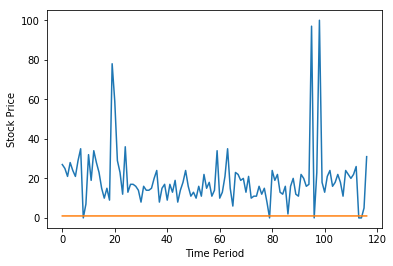

[step: 0] loss: 480230.25
[step: 1] loss: 478058.4375
[step: 2] loss: 476221.75
[step: 3] loss: 474836.5
[step: 4] loss: 473791.9375
[step: 5] loss: 472822.25
[step: 6] loss: 471867.65625
[step: 7] loss: 470937.21875
[step: 8] loss: 469946.25
[step: 9] loss: 468785.25
[step: 10] loss: 467462.59375
[step: 11] loss: 466067.25
[step: 12] loss: 464661.15625
[step: 13] loss: 463262.375
[step: 14] loss: 461892.46875
[step: 15] loss: 460592.46875
[step: 16] loss: 459456.25
[step: 17] loss: 458594.375
[step: 18] loss: 457969.25
[step: 19] loss: 457458.46875
[step: 20] loss: 456989.8125
[step: 21] loss: 456547.25
[step: 22] loss: 456124.0625
[step: 23] loss: 455709.03125
[step: 24] loss: 455300.1875
[step: 25] loss: 454907.71875
[step: 26] loss: 454561.96875
[step: 27] loss: 454303.34375
[step: 28] loss: 454123.625
[step: 29] loss: 453982.90625
[step: 30] loss: 453858.53125
[step: 31] loss: 453741.125
[step: 32] loss: 453628.1875
[step: 33] loss: 453513.90625
[step: 34] loss: 453384.75
[step: 3

[step: 293] loss: 452136.46875
[step: 294] loss: 452136.40625
[step: 295] loss: 452136.375
[step: 296] loss: 452136.34375
[step: 297] loss: 452136.28125
[step: 298] loss: 452136.21875
[step: 299] loss: 452136.15625
[step: 300] loss: 452136.0625
[step: 301] loss: 452136.03125
[step: 302] loss: 452136.03125
[step: 303] loss: 452135.96875
[step: 304] loss: 452135.9375
[step: 305] loss: 452135.90625
[step: 306] loss: 452135.84375
[step: 307] loss: 452135.78125
[step: 308] loss: 452135.71875
[step: 309] loss: 452135.65625
[step: 310] loss: 452135.65625
[step: 311] loss: 452135.59375
[step: 312] loss: 452135.53125
[step: 313] loss: 452135.5
[step: 314] loss: 452135.375
[step: 315] loss: 452135.34375
[step: 316] loss: 452135.28125
[step: 317] loss: 452135.25
[step: 318] loss: 452135.1875
[step: 319] loss: 452135.125
[step: 320] loss: 452135.09375
[step: 321] loss: 452135.09375
[step: 322] loss: 452135.03125
[step: 323] loss: 452134.9375
[step: 324] loss: 452134.90625
[step: 325] loss: 452134.

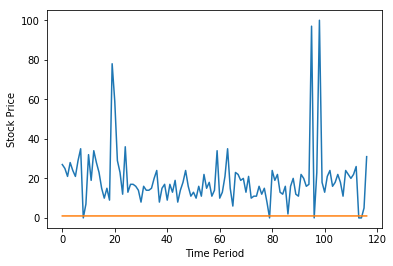

In [23]:
#train parameters
seq_length=7
data_dim=4
hidden_dim=10
output_dim=1
learning_rate=0.01
iterations=500
#기본형식
#기본 인자로는 ds-y로 받고 
#처리함수에서 ds를 받아서 'feature 처리모듈'에서 ds에서 요일(주중, 주말), 월(계절) + 날씨와 같은 추가 요인-값을 받는다.


x=xy
y=xy[:,[-1]]

#build a dataset
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length):
    _x=x[i:i+seq_length]
    _y=y[i+seq_length]
    print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)

# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

#input place holders
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, 1])
# build a LSTM network(input: cell shape, type/ )
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

# use the last cell's output to calculate Y_pred
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=tf.tanh) 
# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)
# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()
